<a href="https://colab.research.google.com/github/lehduong/GINP/blob/master/Rethinking_Network_Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Wed Apr 29 06:52:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Paying more attentions to snapshots of iterative pruning

## 1. Prepare

Clone github repo and install dependencies.

In [0]:
!git clone https://github.com/lehduong/ginp 

Cloning into 'ginp'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (291/291), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 842 (delta 226), reused 186 (delta 134), pack-reused 551
Receiving objects: 100% (842/842), 1.18 MiB | 1.27 MiB/s, done.
Resolving deltas: 100% (590/590), done.


In [0]:
cd /content/ginp/cifar/weight_pruning/

/content/ginp/cifar/weight_pruning


In [0]:
!pip install ptflops

  Created wheel for ptflops: filename=ptflops-0.6.1-cp36-none-any.whl size=8513 sha256=fb74f313d9c3e5b2caa31cc97524922b7970045b2d4cb067a4b2ed04ea3b2a8a
  Stored in directory: /root/.cache/pip/wheels/72/9d/42/7047ed6168fbc3d1d3794f2119a7ba032e28df06a5c6db5ea2
Successfully built ptflops


## 2. Train and Evaluate Networks

### 1. Training from scratch 

Training the baseline model from scratch. Note that, for training from scratch, I have only tested on *cifar/**filter_pruning**/train.py*. 

Change the **--arch** option to desired architecture. It should be one of: resnet56, resnet110, wrn_16_10, vgg16, preresnet110. Read *cifar/xxxx_pruning/models/__init__.py* for more details.

+ For resnet56, 110, preresnet110, vgg: $training\_epochs = 300$, $schedule=[150,225]$, $gamma=0.1$, $lr=0.1$

+ For wrn_16_10: $training\_epochs = 200$, $schedule=[60,120, 160]$, $gamma=0.2$, $lr=0.1$

Currently, I used $weight\_decay=0.0001$ for all models except wideresnet where we set it to $0.0005$ following the original paper.

In [0]:
!python train.py --resume checkpoints/checkpoint.pth.tar -a preresnet164 -d cifar10 --epochs 300 --schedule 150 225 --gamma 0.1 --wd 1e-4 --save checkpoints

### 2. Evaluate trained models
Evaluate trained (or pruned) models with **--evaluate** option and modify **--resume** accordingly to checkpoint

In [0]:
!python train.py -a preresnet164 -d cifar10 --resume checkpoints/model_best.pth.tar  --evaluate --save a

## 3. Pruning

### 1. Filter Pruning

For resnet56, resnet110, preresnet110, wrn_16_10: run following command

In [0]:
!python residualprune.py --dataset cifar100 --arch resnet56 --model checkpoints/cifar100/resnet-56/model_best.pth.tar --save prune_1

For vgg16: run following command

In [0]:
!python vggprune.py --dataset cifar100 --arch vgg16 --model prune_4/checkpoint.pth.tar --save prune_5

### 2. Weight Pruning

Run following command for **all** models.

Note that to apply iterative pruning, we have to increase **precent** at each step manually. 

For example, in first pruning step, we set the --percent option to **0.2** and resume from baseline model; at second pruning step, we increase the --percent option to **0.4** and resume from (finetuned) pruned network of step 1.

In [0]:
!python cifar_prune.py --arch resnet56 --dataset cifar100 --percent 0.3 --resume checkpoints/cifar100/resnet-56/model_best.pth.tar   --save_dir onecycle

## 4. Finetuning
### 1. Finetune for Filter Pruning

To retrain a network, which was pruned by **filter** pruning, run below command.

For all models and datasets, we used *OneCycle* Policy where $max\_lr=0.1$, $initial\_lr=0.01$, $min\_lr=0.0001$

In [0]:
!python finetune.py --lr 0.1 --refine prune_4/pruned.pth.tar --seed 6 --dataset cifar10 --arch preresnet164 --save prune_4

### 2. Finetune for Weight Pruning

To retrain a network pruned by **weight** pruning, run following command.

We used same hyperparameter as retraining for filter pruning.

In [0]:
!python cifar_finetune.py --arch resnet56 --dataset cifar100  --resume onecycle/pruned.pth.tar --save_dir onecycle

## 4. Ensemble finetune

To perform knowledge distillation from ensemble: manually change the **checkpoint_path** variable in *ensemble_finetune.py* then run below command.

For knowledge distillation, we use $lr=0.01$, $schedule=[20,30]$, $gamma=0.2$.

In [0]:
!python ensemble_finetune.py --lr 0.001 --batch-size 128 --refine prune_4/checkpoint.pth.tar --dataset cifar100 --save ts --arch wrn_16_8

## 5. Miscellaneous

Copy files to Google Drive and vice verse...

In [0]:
!cp /content/drive/My\ Drive/GINP/cifar10/pretrained/vgg16_1/cifar10_vgg16_300epochs_9423.zip .

In [0]:
!unzip cifar10_vgg16_300epochs_9423

In [0]:
!ls checkpoints 

checkpoint.pth.tar  log.eps  log.txt  model_best.pth.tar


In [0]:
!scripts/onecycle_vgg16_cifar10.sh

PRUNE 1
==> Preparing dataset cifar10
Files already downloaded and verified
==> creating model 'vgg16'
    Total params: 14.99M
==> Resuming from checkpoint..

Evaluation only
cifar_prune.py:225: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)
Processing |################################| (100/100) Data: 0.008s | Batch: 0.023s | Total: 0:00:02 | ETA: 0:00:01 | Loss: 0.2707 | top1:  94.2300 | top5:  99.7000
Before pruning: Test Loss:  0.27071665, Test Acc:  94.23
Pruning threshold: 0.00010269184713251889
layer index: 2 	 total params: 1728 	 remaining params: 661
layer index: 5 	 total params: 36864 	 remaining params: 13091
layer index: 9 	 total params: 73728 	 remaining params: 71172
layer index: 12 	 total params: 147456 	 remaining params: 146844
layer index: 16 	 total params: 294912 	 remaining params: 293649
layer index: 19 	 total pa

In [0]:
!cp /content/drive/My\ Drive/GINP/cifar100/filter_pruning/onecycle_lr/wrn168_2/prune_5.zip .
!cp /content/drive/My\ Drive/GINP/cifar100/filter_pruning/onecycle_lr/wrn168_2/prune_4.zip .
!cp /content/drive/My\ Drive/GINP/cifar100/filter_pruning/onecycle_lr/wrn168_2/prune_3.zip .
!cp /content/drive/My\ Drive/GINP/cifar100/filter_pruning/onecycle_lr/wrn168_2/prune_2.zip .
!cp /content/drive/My\ Drive/GINP/cifar100/filter_pruning/onecycle_lr/wrn168_2/prune_1.zip .

In [0]:
!unzip prune_5
!unzip prune_4
!unzip prune_3
!unzip prune_2
!unzip prune_1

In [0]:
!chmod +x scripts/onecycle_wrn168_cifar10.sh

In [0]:
!scripts/onecycle_wrn168_cifar10.sh

## 6. Plot loss landscape

In [0]:
!git clone https://github.com/marcellodebernardi/loss-landscapes

Cloning into 'loss-landscapes'...
remote: Enumerating objects: 404, done.
remote: Counting objects: 100% (404/404), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 980 (delta 240), reused 301 (delta 142), pack-reused 576
Receiving objects: 100% (980/980), 7.77 MiB | 10.44 MiB/s, done.
Resolving deltas: 100% (568/568), done.


In [0]:
!mv loss-landscapes/loss_landscapes . 

In [0]:
!touch p.py

In [0]:
BATCH_SIZE = 5000
STEPS = 100
ARCH = 'resnet56'
AFTER = 'onecycle/pruned.pth.tar'
ORIGINAL = 'checkpoints/cifar100/resnet-56/model_best.pth.tar'
DATASET = 'cifar100'

In [0]:
# libraries
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import datasets, transforms
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [18, 12]

# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.metrics
import models as model_module

In [0]:
train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR100('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Pad(4),
                           transforms.RandomCrop(32),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),
                           transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)
criterion = torch.nn.CrossEntropyLoss()  

Files already downloaded and verified


In [0]:
print("=> loading checkpoint '{}'".format(AFTER))
checkpoint = torch.load(AFTER)
model_final = model_module.__dict__[ARCH](DATASET)
model_final.load_state_dict(checkpoint['state_dict'])
model_final = model_final.cuda()
print("=> loading checkpoint '{}'".format(ORIGINAL))
checkpoint = torch.load(ORIGINAL)
model_initial = model_module.__dict__[ARCH](DATASET)
model_initial.load_state_dict(checkpoint['state_dict'])
model_initial = model_initial.cuda()

=> loading checkpoint 'onecycle/pruned.pth.tar'
=> loading checkpoint 'checkpoints/cifar100/resnet-56/model_best.pth.tar'


In [0]:
def accuracy(outputs, targets):
  outputs = torch.argmax(outputs, dim=1)
  return (outputs == y).sum()/float(outputs.shape[0])

In [0]:
# data that the evaluator will use when evaluating loss
x, y = iter(train_loader).__next__()
x, y = x.cuda(), y.cuda()
metric = loss_landscapes.metrics.Loss(accuracy, x, y)

# compute loss data
loss_data = loss_landscapes.linear_interpolation(model_initial, model_final, metric, STEPS, deepcopy_model=True)

In [0]:
!python p.py

Files already downloaded and verified
=> loading checkpoint 'checkpoints/cifar100/resnet-56/model_best.pth.tar'
=> loading checkpoint 'prune_5/finetuned.pth.tar'
=> loading checkpoint 'prune_3/finetuned.pth.tar'
<Figure size 1800x1200 with 1 Axes>


In [0]:
plt.plot([1/STEPS * i for i in range(STEPS)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.savefig('a.pdf')
plt.show()

In [0]:
loss_data_fin = loss_landscapes.random_plane(model_final, metric, 1, STEPS, normalization='filter', deepcopy_model=True)

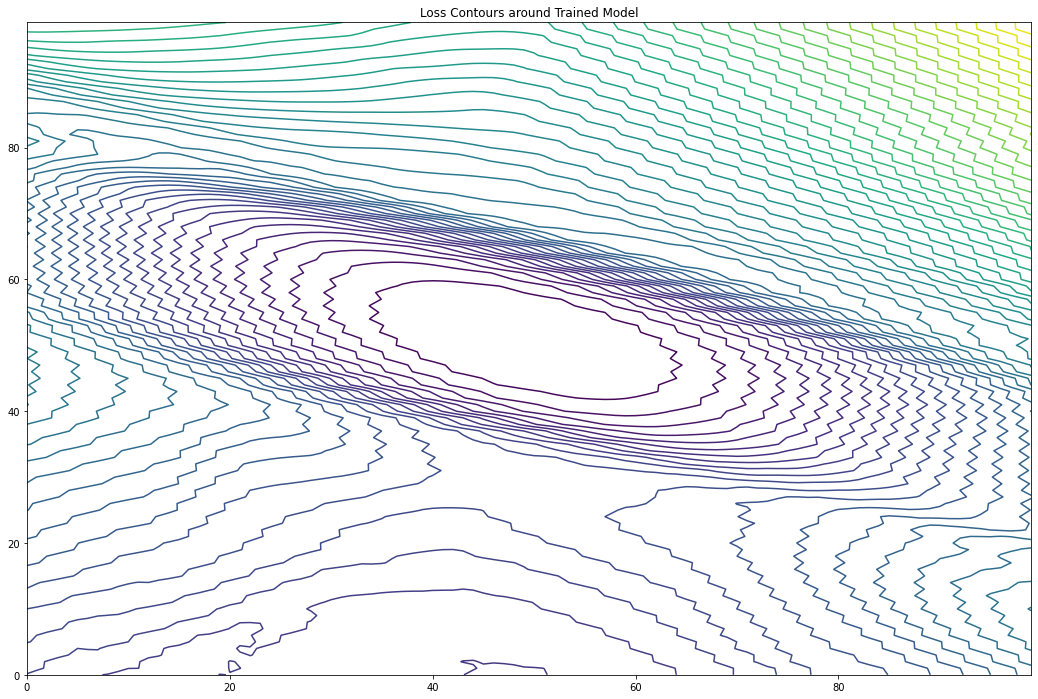

In [0]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

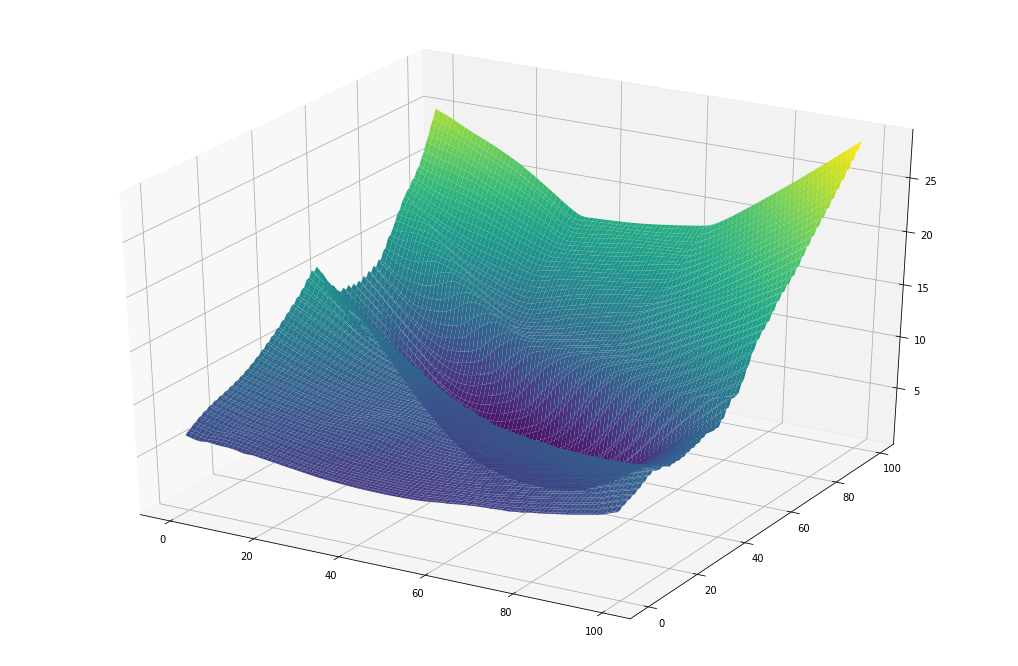

In [0]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
fig.show()

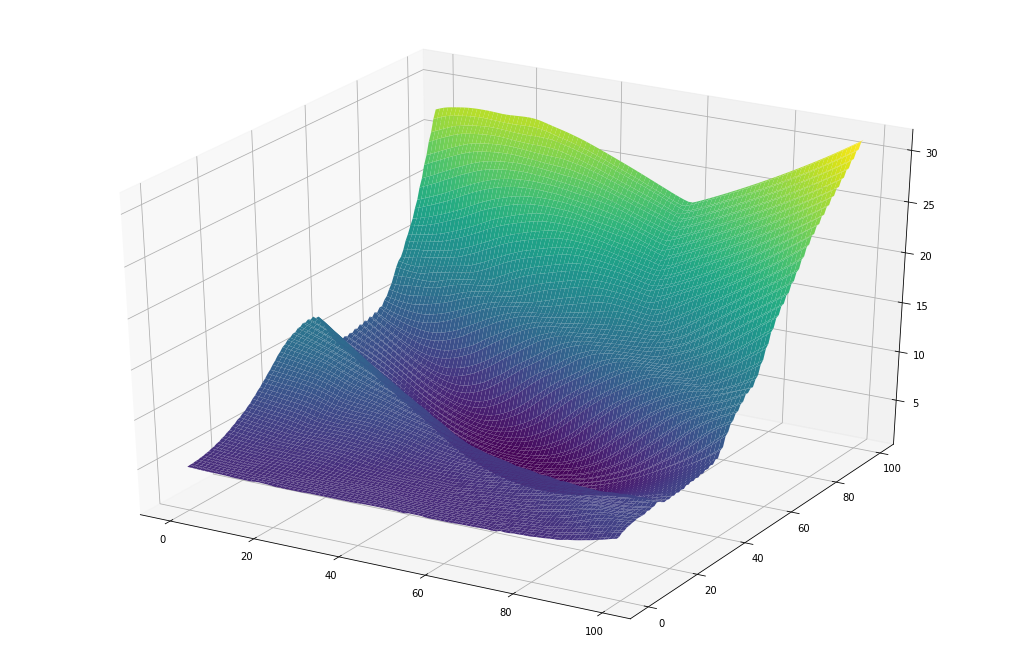

In [0]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
fig.show()

In [0]:
fig.savefig('onecycle.pdf')

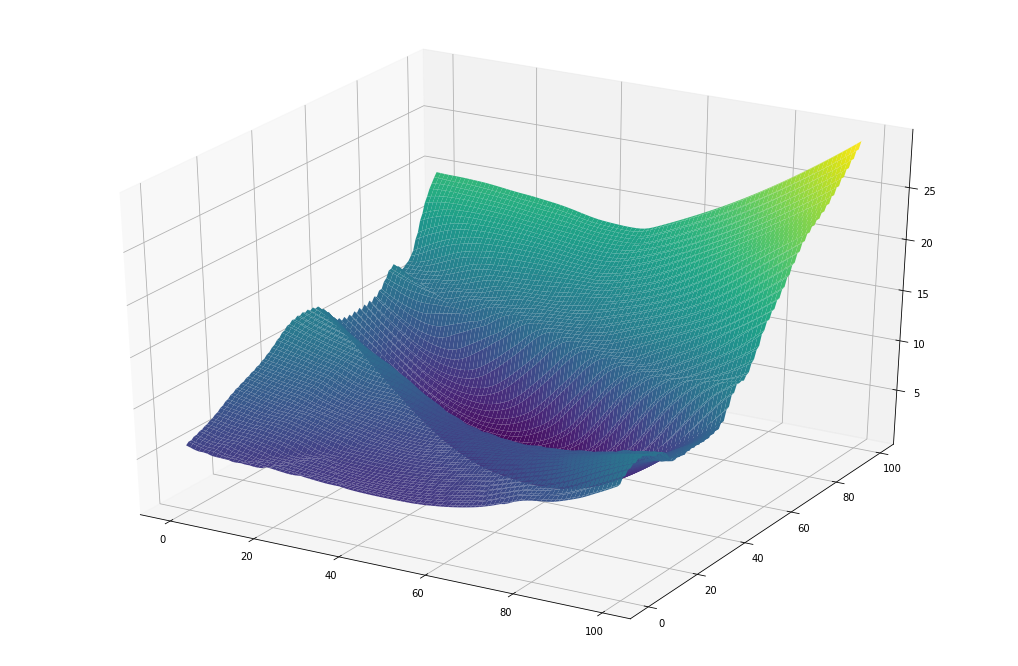

In [0]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
fig.show()

In [0]:
!python p.py

Files already downloaded and verified
=> loading checkpoint 'prune_1/checkpoint.pth.tar'
=> loading checkpoint 'prune_1/checkpoint.pth.tar'


Tocks 9998 tocks [03:35, 46.59 tocks/s]
<Figure size 1800x1200 with 1 Axes>
